# Computer vision and deep learning - Laboratory 5

In this laboratory, you will continue the semantic segmentation mini-project that we started last time. More specifically, you will write the CNN architecture, define the training loop, perform hyperparameter search and evaluate the best segmentation module.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import cv2
import wget
import glob
import wandb
import shutil
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision.transforms import v2

from MyUnetModel import MyUNet


## Building the model

The model that will be used in this laboratory is inspired by the [U-Net](https://arxiv.org/abs/1505.04597) architecture.
U-Net is a fully convolutional neural network comprising two symmetric paths: a contracting path (to capture context) and an expanding path  (which enables precise localization).
The network also uses skip connections between the corresponding layers in the downsampling path to the layer in the upsampling path, and thus directly fast-forwards high-resolution feature maps from the encoder to the decoder network.

The output of the model is an volume with depth C, where C is the number of pixel classes. For example, if you want to classify the pixels into person and background, the output will be a volume of depth 2.
If you want to classify the pixels into face, hair and background the output will be a volume of depth 3.

**Read the U-Net paper and try to understand the architecture.**

An overview of the U-Net architecture is depicted in the figure below:
<img src="https://miro.medium.com/max/1400/1*J3t2b65ufsl1x6caf6GiBA.png"/>




## The downsampling path


For the downsampling path we'll use a convolutional neural network from the pretrained torchvision models.
We'll cover this in detail in the next laboratory session.


## The upsamping path


In the upsampling path, we'll use transposed convolutions to progressively increase the resolution of the activation maps. The layers for the transposed convolution is [ConvTranspose2d](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html).

Let's write a function to implement an upsampling block, consisting of a transposed convolution, a batch normalization block and a ReLu activation.

Remember, the output size $W_o$ of a transposed convolutional layer is:  
\begin{equation}
W_o = (W_i - 1) \cdot S - 2P + F
\end{equation},

where $W_i$ is the size of the input, $S$ is the stride, $P$ is the amount of padding and $F$ is the filter size.


In [4]:
import torch
def upsample_block(x, filters, size, stride = 2):
  """
  x - the input of the upsample block
  filters - the number of filters to be applied
  size - the size of the filters
  """

  # TODO your code here
  # transposed convolution
  # BN
  # relu activation
  x = torch.nn.ConvTranspose2d(x.shape[1], filters, size, stride)(x)
  x = torch.nn.BatchNorm2d(x.shape[1])(x)
  x = torch.nn.ReLU()(x)

  return x

Now let's test this upsampling block.
Change the parameters of of this function and notice how the shape of the output changes.

In [6]:
in_layer = torch.rand((32, 32, 128, 128))

filter_sz = 4
num_filters = 16

for stride in [2, 4, 8]:
  x = upsample_block(in_layer, num_filters, filter_sz, stride)
  print('in shape: ', in_layer.shape, ' upsample with filter size ', filter_sz, '; stride ', stride, ' -> out shape ', x.shape)

  # o = (128 - 1) * 2 + 4 = 258, 254*2 = 508 + 4 = 512, 1016 + 4 = 1020 ok

in shape:  torch.Size([32, 32, 128, 128])  upsample with filter size  4 ; stride  2  -> out shape  torch.Size([32, 16, 258, 258])
in shape:  torch.Size([32, 32, 128, 128])  upsample with filter size  4 ; stride  4  -> out shape  torch.Size([32, 16, 512, 512])
in shape:  torch.Size([32, 32, 128, 128])  upsample with filter size  4 ; stride  8  -> out shape  torch.Size([32, 16, 1020, 1020])


## The down-sampling path


For the down-sampling path we'll use a classical convolutional neural network.

Write a class Encoder which inherits from ``torch.nn.Module`` for the down-sampling path. The model will be composed of several blocks, each block comprising two convolutional layers (with filter size of 3) with a ``ReLu`` non-linearity between them. The blocks of the encoder will be separated by max pooling layers with a size of 2 and a stride of 2.

 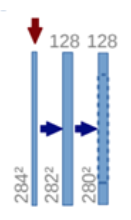

In the constructor of the Encoder class you will pass as parameter a list containing the number of channels used for each encoder block. In the forward function you will return a list containing the outputs of all the encoder blocks (you’ll be using them for the connection between the down-sampling path and the up-sampling path).

You can also use a pre-trained module from torchvision for this. You'll first load the pre-trained weights on ImageNet, and "freeze" these weights during the training process (set required_grad=False for those tensors). The problem is that to create the skip connections required by the U-Net architecture we need access to the feature maps of some intermediate layers in the network and these are not accessible by default.

You should inspect the implementation of the CNN that you chose, make the Encoder class inherit from the model you chose, and in the forward function, return the output of the layers you selected for the skip connections.



## The up-sampling path (Decoder)

In the upsampling path, we'll use transposed convolutions to progressively increase the resolution of the activation maps. The layers for the transposed convolution is [ConvTranspose2d](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html).

Let's write a function to implement an upsampling block, consisting of a transposed convolution, a batch normalization block and a ReLu activation.

Remember, the output size $W_o$ of a transposed convolutional layer is:  
\begin{equation}
W_o = (W_i - 1) \cdot S - 2P + F
\end{equation},

where $W_i$ is the size of the input, $S$ is the stride, $P$ is the amount of padding and $F$ is the filter size.


Similarly to the encoder, the decoder will be composed of several blocks, and each block will consist in a transposed convolution (followed by a batch normalization layer and a ReLU non-linearity) and then by an encoder block.  

 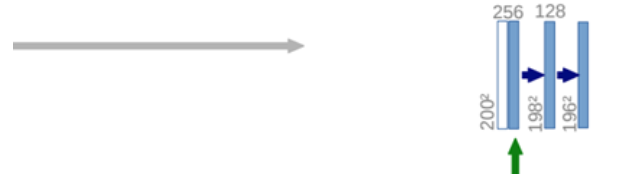

Write a class Decoder  which inherits from ``torch.nn.Module`` to implement the up-samping path; the constructor of this class will get as parameter the depth of each decoder module, and in the forward function you will have two parameters: the input feature map and a list of activations from the encoder (for the skip connections).  



In the forward function, for each block:

- apply the up-sampling operation (followed by batch normalization and ReLU);

- crop the corresponding activation map from the encoder (use CenterCrop) such that is has the same size as the decoder block;

- concatenate these two activation maps (on the channel dimension);

- apply an encoder block on the result;

- pass the result to the next decoder block.



# Simpler implementation

Alternatively, you can choose to implement the entire architecture into a single class.

In the UNet diagram above, the arrows represent the layers in your network.
The blue rectangles represent the feature maps: the number on top of the rectangle is the number of channels of the feature map, while the numbers from the lower left is the spatial shape of the feature map (for example, $572 \times 572$ - is a feature map of height and width $572$)

```
class UNet(torch.nn.Module):
def __init__(num_classes):
    super().__init__()
    # TODO your code here create all the UNET layers
    # enc_11 -> the first convolutional layer from the first encoder block
    # the image is a color image, so the number of channels is 3, while according to the UNet architecture above, the number of output channels is 64
    self.enc_11 = torch.nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 3)
    # enc_12 -> the second convolutional layer from the first encoder block
    # 64 input_channels (the input of enc_11 will be the output of enc_11 that has 64 filters),  
    self.enc_12 = torch.nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3)
    # etc etc
   
```

## Loading dataset, creating dataloaders

In [3]:
from LFWDataset import LFWDataset
from pathlib import Path
from torchvision.transforms import transforms
from torch.utils.data import random_split

dataset = LFWDataset(
    Path('D:\ML\cv_dl\lfw_dataset'), 
    transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.to("cuda")),
    ])
)

random_gen = torch.Generator().manual_seed(69)
train_data, test_data, _= random_split(dataset, [.8, .2, .0], random_gen)

batch_size = 16
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size, shuffle=False) 

print(len(train_dataloader), len(test_dataloader))
print(dataset.__getitem__(0)[0].shape)

147 37
torch.Size([3, 250, 250])


d:\ML\ml_venv_python3.8\lib\site-packages\torch\utils\data\dataset.py:414: UserWarning: Length of split at index 2 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "


## Creating Unet model

In [4]:
from MyUnetModel import MyUNet

num_classes = 3
encoder_channels = [3, 64, 128, 256, 512, 1024]
decoder_channels = [1024, 512, 256, 128, 64]

unet_model = MyUNet(num_classes, encoder_channels, decoder_channels)
unet_model.to('cuda')

testX = torch.rand(15, 3, 250, 250).to('cuda')
output = unet_model(testX)
print(output.shape)
print(unet_model)

torch.Size([15, 3, 250, 250])
MyUNet(
  (encoder): Encoder(
    (blocks): ModuleList(
      (0): Sequential(
        (0): Sequential(
          (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
          (1): ReLU()
          (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
          (3): ReLU()
        )
      )
      (1): Sequential(
        (0): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
          (1): ReLU()
          (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
          (3): ReLU()
        )
      )
      (2): Sequential(
        (0): Sequential(
          (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
          (1): ReLU()
          (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
          (3): ReLU()
        )
      )
      (3): Sequential(
        (0): Sequential(
          (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
          (1): ReLU()
          (2): Conv2d(512, 512, kernel_size=(3, 3),

In [3]:
class StupidNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.convs = torch.nn.Sequential(
            torch.nn.Conv2d(3, 32, padding='same', kernel_size=3),
            torch.nn.Conv2d(32, 32, padding='same', kernel_size=3)
        )
        self.finalFC = torch.nn.Conv2d(32, 3, padding='same', kernel_size=3)
    
    def forward(self, x):
        x = self.convs(x)
        x = self.finalFC(x)
        
        return x

stupid_model = StupidNet()
stupid_model.to('cuda')

testX = torch.rand(15, 3, 250, 250).to('cuda')
output = stupid_model(testX)
print(output.shape)


torch.Size([15, 3, 250, 250])


## Putting it all together

Finally, you should write the UNet class which defines the semantic segmentation model. In this class you will use and connect the Encoder and Decoder classes that you previously wrote. The output of the segmentation module will be a volume with as many channels as the number of classes from the segmentation problem. Basically, each channel c from the output will be a map that stores the probability of each pixel to belong to the class c.

Apply a 1x1 convolution with c channels on the decoder output to obtain the segmentation map.

Finally, to have matching shapes between the network output (segmentation map) and the ground truth data, resize the segmentation map using ``torch.nn.functional.interpolate``.


### The training loop


Now, it’s time to write the training loop.  

You remember the steps from the previous labs. You need a train and a test DataLoader and you must first define the loss function cross entropy and select an optimizer.

Then:

- Get a batch of training data from the DataLoader
- Zero out the optimizer’s gradients
- Perform the forward pass
- Calculate and store the loss and the accuracy based on the predictions and the labels from the dataset
- Tell the optimizer to perform one learning step - that is, adjust the model’s learning weights based on the observed gradients for this batch, according to the optimization algorithm we chose
- Evaluate the model on the validation/test set. Store the loss and the accuracy on the validation/test set.

In [5]:
from TrainUnet import train, loss_fn_unet

# training
lr = 0.001 
optimizer = torch.optim.Adam(unet_model.parameters(), lr=lr)

loss_fn = loss_fn_unet
num_of_epochs = 40

wandb.init(
    project="cv-dl", 
    config={
        "epochs": num_of_epochs,
        "batch_size": batch_size,
        "lr": lr
    }
)
train_losses, test_losses = train(unet_model, num_of_epochs, train_dataloader, test_dataloader, optimizer, loss_fn)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: bejan-andrei-personal (deiubejan). Use `wandb login --relogin` to force relogin


EPOCH 0:
batch: 0 loss: 1.7481364011764526
batch: 1 loss: 1.5688786506652832
batch: 2 loss: 1.3305222988128662
batch: 3 loss: 1.3387815952301025
batch: 4 loss: 1.27056884765625
batch: 5 loss: 1.3115684986114502
batch: 6 loss: 1.2546135187149048
batch: 7 loss: 1.2546207904815674
batch: 8 loss: 1.2819997072219849
batch: 9 loss: 1.1591191291809082
batch: 10 loss: 1.2005635499954224
batch: 11 loss: 1.2345664501190186
batch: 12 loss: 1.0641651153564453
batch: 13 loss: 1.093583345413208
batch: 14 loss: 1.1422653198242188
batch: 15 loss: 1.033637285232544
batch: 16 loss: 1.2008408308029175
batch: 17 loss: 1.0517992973327637
batch: 18 loss: 1.0581486225128174
batch: 19 loss: 0.9113483428955078
batch: 20 loss: 1.1418979167938232
batch: 21 loss: 0.951263964176178
batch: 22 loss: 0.9863956570625305
batch: 23 loss: 0.9943786263465881
batch: 24 loss: 0.929864764213562
batch: 25 loss: 1.0062952041625977
batch: 26 loss: 0.8595654964447021
batch: 27 loss: 0.8106796145439148
batch: 28 loss: 1.090808868

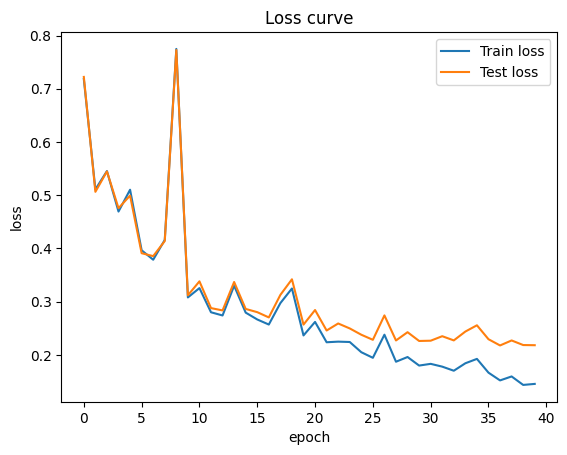

In [6]:
import matplotlib.pyplot as plt

# show loss curve

plt.figure()

plt.plot(range(0, num_of_epochs), train_losses, label='Train loss')
plt.plot(range(0, num_of_epochs), test_losses, label='Test loss')
plt.title("Loss curve")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


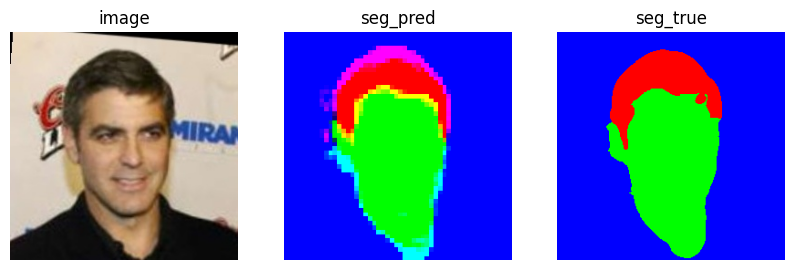

In [7]:
import random
imageId = random.randint(0, len(test_data)-1)
image, truth = test_data.__getitem__(imageId)

pred = unet_model(image.unsqueeze(0)).cpu().detach()[0]
image = image.cpu()
truth = truth.cpu()

figure = plt.figure(figsize=(10, 10))

figure.add_subplot(1, 3, 1)
plt.title('image')
plt.axis("off")
plt.imshow(image.numpy().transpose(1, 2, 0))

figure.add_subplot(1, 3, 2)
plt.title('seg_pred')
plt.axis("off")
plt.imshow(pred.numpy().transpose(1, 2, 0), cmap="gray")

figure.add_subplot(1, 3, 3)
plt.title('seg_true')
plt.axis("off")
plt.imshow(truth.numpy().transpose(1, 2, 0), cmap="gray")
plt.show()

## Evaluation metrics

Finally, you will implement several segmentation metrics to evaluate the model you've just trained. As usual, try to implement these metrics without using any for loops.

In the remainder of this section we'll use the following notation:
- $n_{ij}$ - the total number of pixels classified to class
j but actually belonging to class i; $i, j \in 1, .., C$;
- $t_i = \sum_{j = 1}^{C} n_{ij}$ - the total number of pixels belonging to class $i$ (in the ground truth segmentation mask);
- $C$ - the total number of classes in the segmentation problem.

### Mean pixel accuracy

Pixel accuracy is the simplest image segmentation metric; it is defined as the percentage of pixels that were correctly classified by the model.

\begin{equation}
p_a = \frac{1}{C} \frac{\sum_{i}^{C} n_{ii}}{\sum_{i}^{C} t_i}
\end{equation}

This metric is not that relevant for class imbalanced problems (which occurs for most segmentation problems).

### Intersection over Union (IoU)

the intersection over union metric is defined as the ratio between the area of intersection and the area of union (between the predicted segmentation mask and the ground truth segmentation mask of a single class).
In case of a multi-class segmentation problem, we simple average the IoUs over all the classes. This metric is called mean Intersection over Union (mIou).

\begin{equation}
mIoU = \frac{1}{C} \sum_{i = 1}^{C} \frac{n_{ii}}{t_i - n_{ii} + \sum_{j = 1}^{C} n_{ji}}
\end{equation}

The ideal value for this metric is 1; usually values lower than 0.6 indicate a very bad performance.

### Frequency Weighted Intersection over Union

The frequency weighted over union metric is similar to mean IoU, but the values are weighted with the adequate frequencies of the pixels.

\begin{equation}
fIou = (\sum_{i = 1}^{k} t_i)^{-1}   \sum_{i = 1}^{C} t_i \cdot \frac{n_{ii}}{t_i - n_{ii} + \sum_{j = 1}^{C} n_{ji}}
\end{equation}

The values of this metric lie in the interval [0, 1], and the ideal value for this metric is 1.

Compute and report these metrics for your trained model(s).



In [8]:
from UnetEval import model_eval

model_eval(unet_model, test_dataloader)
torch.save(unet_model, 'saved_model.pth')

# artifact = wandb.Artifact('saved_model', type='model')
# artifact.add_file('saved_model.pth')
# wandb.log_artifact(artifact)
wandb.finish()

mpa = 0.3155818283557892, iou = 0.33333333333333276, fwiou = 0.8988761769137166


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_loss,▇▅▅▄▅▃▃▃█▂▃▂▂▃▂▂▂▂▃▁▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,▇▅▅▅▅▄▄▄█▃▃▃▂▃▃▂▂▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▂▁▁▁▁▁
epoch,39
fwiou,0.89888
iou,0.33333
mpa,0.31558
test_loss,0.21808
train_loss,0.14538


# Wandb


This time you will use [wandb](https://wandb.ai/) to track your experiments and perform hyperparameter search.


1. Log the loss and several metrics after each epoch: use ``wandb.log()`` method within your training loop after each epoch to log the loss and at least two metrics on the train and the validation dataset.


2. Use a ``wandb.Table`` to visualize the predictions on the validation dataset across the training process. You can find more details [here](https://colab.research.google.com/github/wandb/examples/blob/master/colabs/datasets-predictions/W%26B_Tables_Quickstart.ipynb#scrollTo=tbOiat0mrWA2).


3. [Artifacts](https://docs.wandb.ai/guides/artifacts/construct-an-artifact) are used to track and version any serialized data as the inputs and outputs.


"W&B Artifacts was designed to make it effortless to version your datasets and models, regardless of whether you want to store your files with W&B or whether you already have a bucket you want W&B to track. Once you've tracked your datasets or model files, W&B will automatically log each and every modification, giving you a complete and auditable history of changes to your files."


Create a class ModelCheckpoint which will be responsible for tracking the best N checkpoints across the training process. This class will monitor a metric, and if the value for that metric is higher/lower (depending on whether the ) than the current max/min, it will save a checkpoint of the model.
Also, you should ensure that at a given time only N checkpoints are being saved. So, if the number of saved checkpoints is greater than N, you should perform a cleanup.


```
    def __call__(self, model, epoch, metric_val):
        must_save = metric_val < self.best_metric_val if self.decreasing_metric else metric_val > self.best_metric_val
        if must_save:
            self.best_metric_val = metric_val
            # TODO use torch.save to save the model
            # TODO use the function below to log the model artifact
       
        # TODO if needed, perform cleanup
   
    def write_artifact(self, path, model_path, metric_val):
        artifact = wandb.Artifact(filename, type='model', metadata={'metric': metric_val})
        artifact.add_file(model_path)
        wandb.run.log_artifact(artifact)    


```


4. You will also use [wandb sweeps](https://docs.wandb.ai/guides/sweeps) to automate hyperparameter tuning. This module explores different combinations of hyperparameters to help users find the best configuration for their models.

[Here](https://www.youtube.com/watch?v=9zrmUIlScdY&ab_channel=Weights%26Biases) you can find a video tutorial on how you can use sweeps in wandb and [here](https://colab.research.google.com/github/wandb/examples/blob/master/colabs/pytorch/Organizing_Hyperparameter_Sweeps_in_PyTorch_with_W%26B.ipynb) the corresponding colab.


Random Search is a hyperparameter optimization technique that involves randomly sampling hyperparameter values within specified ranges or distributions. It explores the hyperparameter space by selecting combinations randomly, allowing for a broad search across various configurations without following a specific pattern or grid.


Grid Search is a method where hyperparameter values are exhaustively tested across a predefined grid or set of values. It evaluates the model's performance for each combination of hyperparameters within the specified ranges, systematically covering the entire search space to find the optimal configuration.


Perform hyperparameter search using wandb sweeps (more details [here](https://wandb.ai/wandb_fc/articles/reports/Running-Hyperparameter-Sweeps-to-Pick-the-Best-Model--Vmlldzo1NDQ0OTIy)) for the learning rate and at least one other parameter.
- first perform a random search as a preliminary exploration to identify "promising" values for your hyperparameters;
- then apply a grid search on this range, to perform a more focused investigation into promising regions for finer optimization.



In [5]:
import wandb

wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: bejan-andrei-personal (deiubejan). Use `wandb login --relogin` to force relogin


True

In [225]:
sweep_config = {
    'method': 'random'
}

metric = {
    'name': 'train_loss',
    'goal': 'minimize'
}
sweep_config['metric'] = metric

parameters_dict = {
    'optimizer': {
        'values': ['adam', 'sgd']
    },
    'learning_rate': {
        'distribution': 'uniform', 
        'min': 0.0001,
        'max': 0.01
    }
}
sweep_config['parameters'] = parameters_dict
parameters_dict.update({
    'epochs': {
        'value': 3
    }
})



In [227]:
sweep_id = wandb.sweep(sweep_config, project='cv-dl-sweep3')

Create sweep with ID: k2t1gctr
Sweep URL: https://wandb.ai/deiubejan/cv-dl-sweep3/sweeps/k2t1gctr


In [228]:
def train_sweep():
    wandb.init()
    config = wandb.config

    num_classes = 3
    encoder_channels = [3, 64, 128, 256, 512, 1024]
    decoder_channels = [1024, 512, 256, 128, 64]

    model = MyUNet(num_classes, encoder_channels, decoder_channels)
    model.to('cuda')

    lr = config.learning_rate
    if config.optimizer == "sgd":
        optimizer = torch.optim.SGD(model.parameters(),
                              lr=lr, momentum=0.9)
    elif config.optimizer == "adam":
        optimizer = torch.optim.Adam(model.parameters(),
                               lr=lr)
    num_epochs = config.epochs

    loss_fn = loss_fn_unet
    train_losses, test_losses = train(unet_model, num_epochs, train_dataloader, test_dataloader, optimizer, loss_fn)
    wandb.finish()

In [229]:
wandb.agent(sweep_id, train_sweep, count = 5)

wandb: Agent Starting Run: 0dkbwcmd with config:
wandb: 	epochs: 3
wandb: 	learning_rate: 0.002267430079193743
wandb: 	optimizer: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


EPOCH 0:
batch: 0 loss: 1.3681957721710205
batch: 1 loss: 1.2198683023452759
LOSS train 1.3034272193908691 valid 1.2366719245910645
EPOCH 1:
batch: 0 loss: 1.3081495761871338
batch: 1 loss: 1.2883977890014648
LOSS train 1.307039737701416 valid 1.2366671562194824
EPOCH 2:
batch: 0 loss: 1.3531968593597412
batch: 1 loss: 1.2370600700378418
LOSS train 1.299464225769043 valid 1.236671805381775


epoch,▁▅█
test_loss,█▁█
train_loss,▅█▁
epoch,2
test_loss,1.23667
train_loss,1.29946


wandb: Agent Starting Run: 4j1xcmpa with config:
wandb: 	epochs: 3
wandb: 	learning_rate: 0.006014908978829932
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


EPOCH 0:
batch: 0 loss: 1.3106142282485962
batch: 1 loss: 1.2856006622314453
LOSS train 1.293941617012024 valid 1.236670732498169
EPOCH 1:
batch: 0 loss: 1.317772388458252
batch: 1 loss: 1.2774510383605957
LOSS train 1.2982491254806519 valid 1.2366726398468018
EPOCH 2:
batch: 0 loss: 1.2640273571014404
batch: 1 loss: 1.338935375213623
LOSS train 1.300243616104126 valid 1.2366694211959839


epoch,▁▅█
test_loss,▄█▁
train_loss,▁▆█
epoch,2
test_loss,1.23667
train_loss,1.30024


wandb: Agent Starting Run: rxwveuhp with config:
wandb: 	epochs: 3
wandb: 	learning_rate: 0.00521485675687738
wandb: 	optimizer: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


EPOCH 0:
batch: 0 loss: 1.3092992305755615
batch: 1 loss: 1.2870924472808838
LOSS train 1.2983554601669312 valid 1.2366671562194824
EPOCH 1:
batch: 0 loss: 1.3761078119277954
batch: 1 loss: 1.210420846939087
LOSS train 1.3003973960876465 valid 1.2366628646850586
EPOCH 2:
batch: 0 loss: 1.3242220878601074
batch: 1 loss: 1.26996910572052
LOSS train 1.2988919019699097 valid 1.2366611957550049


epoch,▁▅█
test_loss,█▃▁
train_loss,▁█▃
epoch,2
test_loss,1.23666
train_loss,1.29889


wandb: Agent Starting Run: sxxuqg2t with config:
wandb: 	epochs: 3
wandb: 	learning_rate: 0.00624316223742304
wandb: 	optimizer: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


EPOCH 0:
batch: 0 loss: 1.263850450515747
batch: 1 loss: 1.3392689228057861
LOSS train 1.2971761226654053 valid 1.2366572618484497
EPOCH 1:
batch: 0 loss: 1.3317407369613647
batch: 1 loss: 1.2614479064941406
LOSS train 1.299228549003601 valid 1.236659288406372
EPOCH 2:
batch: 0 loss: 1.3284153938293457
batch: 1 loss: 1.2652504444122314
LOSS train 1.2985496520996094 valid 1.2366623878479004


epoch,▁▅█
test_loss,▁▄█
train_loss,▁█▆
epoch,2
test_loss,1.23666
train_loss,1.29855


wandb: Agent Starting Run: mlmski1d with config:
wandb: 	epochs: 3
wandb: 	learning_rate: 0.006595205479649615
wandb: 	optimizer: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


EPOCH 0:
batch: 0 loss: 1.3867543935775757
batch: 1 loss: 1.198582649230957
LOSS train 1.3069093227386475 valid 1.2366628646850586
EPOCH 1:
batch: 0 loss: 1.26625657081604
batch: 1 loss: 1.3358538150787354
LOSS train 1.3039778470993042 valid 1.2366749048233032
EPOCH 2:
batch: 0 loss: 1.3358216285705566
batch: 1 loss: 1.2568244934082031
LOSS train 1.3053905963897705 valid 1.2366752624511719


epoch,▁▅█
test_loss,▁██
train_loss,█▁▄
epoch,2
test_loss,1.23668
train_loss,1.30539



### FOR LAB 6

In [9]:
model = torch.load('saved_model.pth')

scripted_model = torch.jit.script(unet_model)
scripted_model.save("unet_model.pt")

In [4]:
stupid_model.eval()

# Create a sample input tensor (change according to your model's input requirements)
example_input = torch.randn(1, 3, 250, 250)

# Script the model
scripted_model = torch.jit.script(stupid_model)

# Save the scripted model to a file
scripted_model.save("scripted_my_stupid_model.pt")